In [1]:
# Define model
import tensorflow_hub as hub
import keras.layers as L
import keras.losses as losses
import keras.models as M
import keras.optimizers as opt
from keras.utils import to_categorical

Using TensorFlow backend.


In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy 
import re
from sklearn import cross_validation, metrics
import seaborn as sns
%matplotlib inline

In [187]:
# Plot settings
plt.style.use('seaborn-dark-palette')
plt.interactive(True)
plt.rcParams['figure.figsize'] = (20, 8)

In [4]:
# GLoVE vector dictionary
vector = None

In [267]:
df = pd.read_csv('../../data/1900-01-01-2019-02-18-India.csv')

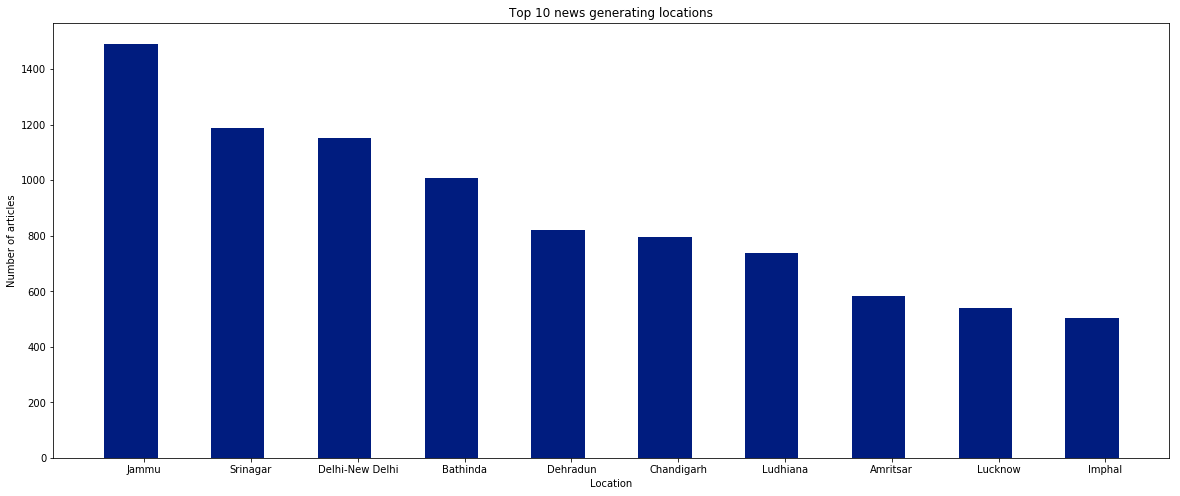

In [268]:
counter = Counter(df.location)
counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:10]
counter = np.array(counter)

places, counts = counter[:, 0].tolist(), counter[:, 1].astype(np.float32)
indices = np.arange(len(counts))
width = 1

plt.xlabel("Location")
plt.ylabel("Number of articles")
plt.interactive(True)

plt.xticks(indices + 0.125, places)
plt.title("Top 10 news generating locations")
_ = plt.bar(indices, counts, 0.5)

In [269]:
df['event_date'] = pd.to_datetime(df['event_date'])
df.sort_values(by=['event_date'], inplace=True)

In [270]:
dates = pd.date_range(start=df.iloc[0]['event_date'], end=df.iloc[-1]['event_date'])
print("Number of days -", len(dates))

Number of days - 1136


In [271]:
dates[0], dates[-1]

(Timestamp('2016-01-01 00:00:00', freq='D'),
 Timestamp('2019-02-09 00:00:00', freq='D'))

In [272]:
df = df[df['location'] == "Dehradun"]

num_events = np.zeros(len(dates))
i = 0
for date in dates:
    num_events[i] += len(df[df['event_date'] == date])
    i += 1

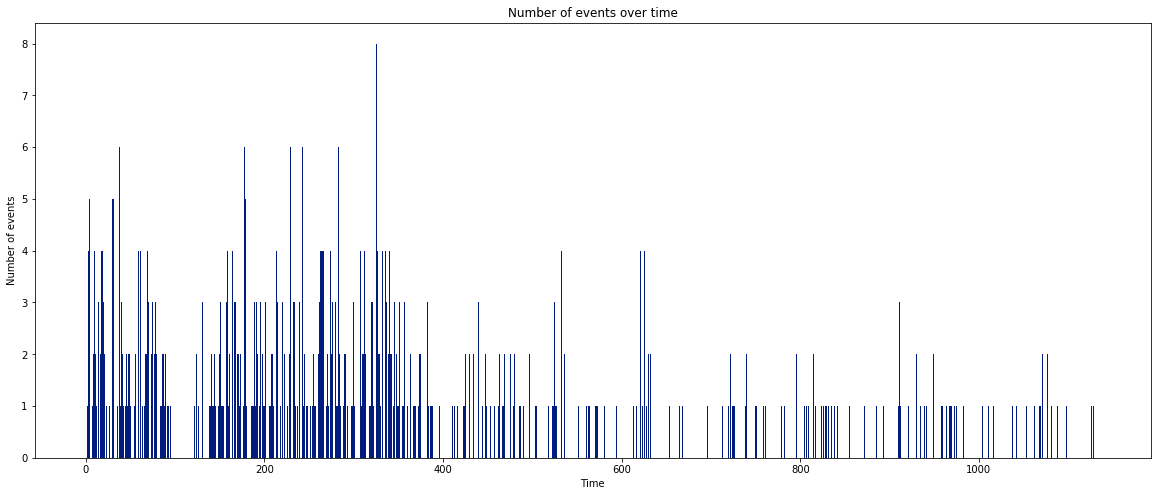

In [273]:
plt.title("Number of events over time")
plt.xlabel("Time")
plt.ylabel("Number of events")
_ = plt.bar(np.arange(len(num_events)), num_events)

In [274]:
news_articles = df.notes

In [275]:
def get_glove_dict():
    """
    Inputs - None
    
    Returns - Dict below
    
    Create a dict with word as key and word vector as value
    """
    d = {}
    f = open("../../glove_vectors/glove.6B.300d.txt", 'r')
    for row in f:
        row = row.replace('\n', '').split(" ")
        word = row[0]
        vector = np.array([float(x) for x in row[1:]])
        d[word] = vector
    f.close()
    return d

def generate_labels(num_events, num_days=2, days_window=2):
    """
    Inputs - 
        num_events - as generated as above 
        num_days - the number of days to after which we 
                   look for the occurence of an event.
                   Basically, the future
        day_window - If an event occurs in a window of days
                     after num_days
    
    Returns - Returns labels generated as below
    
    Generate labels by using the future events, basically
    look-ahead to create labels. If an event occurs from 
    i to i + num_days, then label is 1.0 else 0.0
    """
    n = len(num_events)
    labels = np.zeros(n - num_days - days_window)
    for i in range(n - num_days - days_window):
        labels[i] = 1.0 if sum(num_events[i + num_days: i + num_days + days_window] > 0) else 0.0
    return labels
    

In [276]:
if vector is None:
    vector = get_glove_dict()

In [277]:
num_days, days_window = 2, 4
labels = generate_labels(num_events, num_days, days_window)

In [278]:
print(labels.shape)

(1130,)


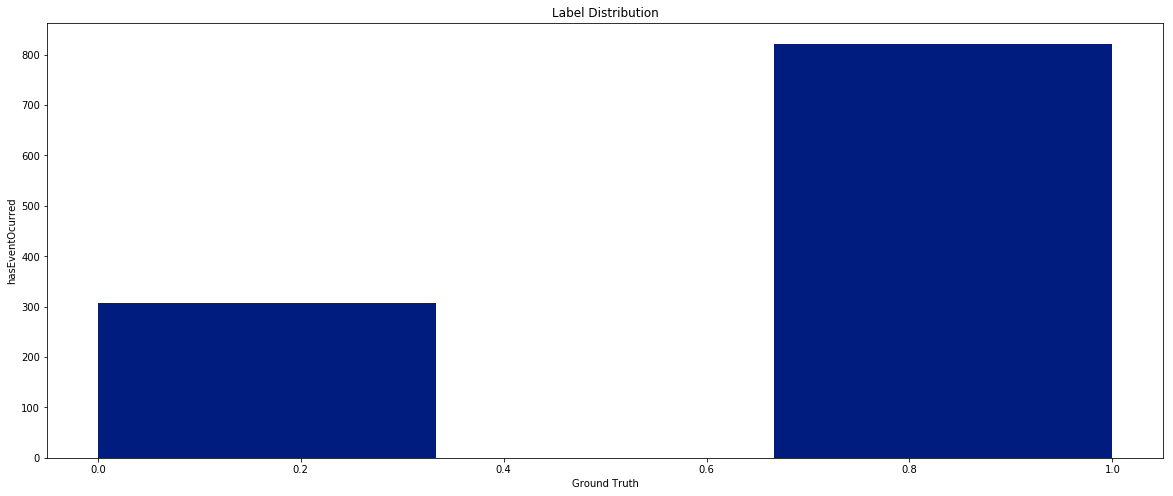

In [279]:
plt.title('Label Distribution')
plt.xlabel('Ground Truth')
plt.ylabel('hasEventOcurred')
_ = plt.hist(labels, bins=3, range=(0, 1))

In [280]:
# Tokenizer
nlp = spacy.load('en_core_web_sm')

# Generate sentence vectors
sentence_vectors = []
regexp = r'/[.,\/#!$%\^&\*;:{}=\-_`~()]/g'
num_sentences = len(news_articles)

for i, sentence in enumerate(news_articles):
    if i % 100 == 0:
        print (i, " / ", num_sentences, "done!")
    tokens = [t.text.lower() for t in nlp(sentence)]
    temp = []
    for token in tokens:
        vec = vector.get(token)
        if vec is None:
            vec = vector['unk']
        temp.append(vec)
    sentence_vectors.append(temp)
            

0  /  822 done!
100  /  822 done!
200  /  822 done!
300  /  822 done!
400  /  822 done!
500  /  822 done!
600  /  822 done!
700  /  822 done!
800  /  822 done!


In [281]:
# For the sentence vector, currently, simply just use average of all words vectors
for i, vecs in enumerate(sentence_vectors):
    sentence_vectors[i] = np.mean(vecs, axis=0)

In [282]:
sentence_vectors = np.array(sentence_vectors)
print("Sentence vector shape -", sentence_vectors.shape)

vector_dim = sentence_vectors.shape[-1]

Sentence vector shape - (822, 300)


In [283]:
df.index = np.arange(len(df))
df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,2032195,356,IND42,42.0,2016-01-03,2016,1,Riots/Protests,Protesters (India),NaN,6,Police Forces of India (2014-),NaN,1,16,Southern Asia,India,Uttarakhand,Dehradun,Dehradun,Dehradun,30.3229,78.0316,1,The Times of India (TOI),National,Agitating pre-2009 PhD holders under the aegis...,0,1542756337,IND
1,2033875,356,IND61,61.0,2016-01-04,2016,1,Riots/Protests,Protesters (India),NaN,6,NaN,NaN,0,60,Southern Asia,India,Uttarakhand,Dehradun,Dehradun,Dehradun,30.3229,78.0316,1,The Pioneer (India),National,Dehradun Gram Pradhan Sangathan held a protest...,0,1542756339,IND
2,2033964,356,IND62,62.0,2016-01-04,2016,1,Riots/Protests,Protesters (India),Teachers (India),6,NaN,NaN,0,60,Southern Asia,India,Uttarakhand,Dehradun,Dehradun,Dehradun,30.3229,78.0316,1,The Times of India (TOI),National,UTA members protested after the National Counc...,0,1542756339,IND
3,2035210,356,IND77,77.0,2016-01-04,2016,1,Riots/Protests,Protesters (India),INC: Indian National Congress,6,NaN,NaN,0,60,Southern Asia,India,Uttarakhand,Dehradun,Dehradun,Dehradun,30.3229,78.0316,1,The Tribune,Subnational,Members of the Congress city unit held a prote...,0,1542756340,IND
4,2035125,356,IND76,76.0,2016-01-04,2016,1,Riots/Protests,Protesters (India),INC: Indian National Congress,6,NaN,NaN,0,60,Southern Asia,India,Uttarakhand,Dehradun,Dehradun,Dehradun,30.3229,78.0316,1,The Tribune,Subnational,Workers of the city Congress staged a protest ...,0,1542756340,IND


In [284]:
sentence_dict = {}
for date in dates:
    temp_df = df[df['event_date'] == date]
    
    if len(temp_df) == 0:
        sentence_dict[date] = (np.zeros(vector_dim))

    else:
        indices = list(temp_df.index)
        sentence_dict[date] = sentence_vectors[indices]

    

### Using average of averages

In [285]:
vec_date = []
for date in dates:
    arr = sentence_dict[date].reshape(-1, vector_dim)
    vec_date.append(np.mean(arr, axis=0))

In [286]:
history = 10
n = len(dates)

In [287]:
x, y = [], []
for i in range(history, n - num_days - days_window):
    x.append(vec_date[i - history: i])
    y.append(labels[i])

In [301]:
x, y = np.array(x), np.array(y)
x, y = x[p], y[p]

In [302]:
print(x.shape, y.shape)

(1117, 10, 300) (1117,)


In [303]:
split = int(len(x) * 0.8)
xtrain, xtest = x[:split], x[split:]
ytrain, ytest = y[:split], y[split:]
ytrain, ytest = to_categorical(ytrain), to_categorical(ytest) 

In [304]:
model = M.Sequential()
model.add(L.Conv1D(10, input_shape=(history, vector_dim), kernel_size=(1)))
model.add(L.BatchNormalization())
model.add(L.Flatten())
model.add(L.Dense(10))
model.add(L.BatchNormalization())
model.add(L.Dense(2))
model.add(L.Activation('softmax'))
opzr = opt.Adam(0.001)
model.compile(opzr, loss=losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14_input (InputLayer) (None, 10, 300)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 10, 10)            3010      
_________________________________________________________________
batch_normalization_27 (Batc (None, 10, 10)            40        
_________________________________________________________________
flatten_14 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1010      
_________________________________________________________________
batch_normalization_28 (Batc (None, 10)                40        
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 22        
__________

In [305]:
print('Train shape -', xtrain.shape)
print('Test shape -', xtest.shape)

Train shape - (893, 10, 300)
Test shape - (224, 10, 300)


In [306]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=32, epochs=100)

Train on 893 samples, validate on 224 samples
Epoch 1/100
893/893 [==============================] - 2s 2ms/step - loss: 0.7043 - acc: 0.6159 - val_loss: 0.5929 - val_acc: 0.6339
Epoch 2/100
893/893 [==============================] - 0s 127us/step - loss: 0.5896 - acc: 0.6753 - val_loss: 0.5659 - val_acc: 0.6473
Epoch 3/100
893/893 [==============================] - 0s 126us/step - loss: 0.5539 - acc: 0.6909 - val_loss: 0.5569 - val_acc: 0.6652
Epoch 4/100
893/893 [==============================] - 0s 129us/step - loss: 0.5227 - acc: 0.7178 - val_loss: 0.5532 - val_acc: 0.6652
Epoch 5/100
893/893 [==============================] - 0s 126us/step - loss: 0.5013 - acc: 0.7424 - val_loss: 0.5384 - val_acc: 0.6786
Epoch 6/100
893/893 [==============================] - 0s 145us/step - loss: 0.4897 - acc: 0.7436 - val_loss: 0.5352 - val_acc: 0.6830
Epoch 7/100
893/893 [==============================] - 0s 154us/step - loss: 0.4661 - acc: 0.7525 - val_loss: 0.5616 - val_acc: 0.6607
Epoch 8/100

Epoch 61/100
893/893 [==============================] - 0s 140us/step - loss: 0.1072 - acc: 0.9574 - val_loss: 0.7049 - val_acc: 0.7545
Epoch 62/100
893/893 [==============================] - 0s 125us/step - loss: 0.0963 - acc: 0.9507 - val_loss: 0.8388 - val_acc: 0.7500
Epoch 63/100
893/893 [==============================] - 0s 121us/step - loss: 0.1146 - acc: 0.9552 - val_loss: 1.0810 - val_acc: 0.7009
Epoch 64/100
893/893 [==============================] - 0s 131us/step - loss: 0.1069 - acc: 0.9440 - val_loss: 0.9948 - val_acc: 0.6875
Epoch 65/100
893/893 [==============================] - 0s 149us/step - loss: 0.0975 - acc: 0.9507 - val_loss: 0.8001 - val_acc: 0.7277
Epoch 66/100
893/893 [==============================] - 0s 145us/step - loss: 0.1002 - acc: 0.9574 - val_loss: 0.9242 - val_acc: 0.7009
Epoch 67/100
893/893 [==============================] - 0s 136us/step - loss: 0.0989 - acc: 0.9462 - val_loss: 0.9853 - val_acc: 0.6920
Epoch 68/100
893/893 [==========================

In [307]:
if model.loss == losses.binary_crossentropy:
    pred = model.predict(xtest)
    ytest_ = ytest
else:
    pred = np.argmax(model.predict(xtest), axis=1)
    ytest_ = np.argmax(ytest, axis=1)

In [308]:
threshold = 0.5
pred[pred > threshold] = 1.
pred[pred <= threshold] = 0.

In [309]:
print(metrics.classification_report(ytest_, pred))

             precision    recall  f1-score   support

          0       0.52      0.72      0.60        64
          1       0.87      0.73      0.79       160

avg / total       0.77      0.73      0.74       224



In [312]:
conf_mat = metrics.confusion_matrix(ytest_, pred)
conf_mat = conf_mat * 100. / np.sum(conf_mat, axis=0)

In [313]:
conf_mat.T

array([[51.68539326, 48.31460674],
       [13.33333333, 86.66666667]])

### Using news articles as such

In [601]:
history = 5
n = len(dates)

In [ ]:
x, y = [], []
for date in dates:
    sentence_vecs = sentence_dict[date]
    

In [738]:
vector['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [740]:
for token in nlp(sentence):
    print(token.)